# Homework 2
### Sean Morton, ME449

# Problem 1: Explanation
See below for the code, and then later on, there are answers to the questions in the HW.

In [1]:
#imports
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

In [2]:
import core as mr
import numpy as np
import pandas as pd

from IPython.core.display import HTML

In [3]:
#variables determined from project description
W1 = 0.109 #changed mm to m
W2 = 0.082
L1 = 0.425
L2 = 0.392
H1 = 0.089
H2 = 0.095

Blist = np.matrix([
    [0,  1, 0, (W1 + W2),          0, (L1 + L2)],
    [0,  0, 1,        H2, -(L1 + L2),         0],
    [0,  0, 1,        H2,        -L2,         0],
    [0,  0, 1,        H2,          0,         0],
    [0, -1, 0,       -W2,          0,         0],
    [0,  0, 1,         0,          0,         0]
]).T

Tsd = [
    [-1, 0, 0, -0.2],
    [0,  0, 1,  0.6],
    [0,  1, 0, 0.35],
    [0,  0, 0,    1]
]

M = np.matrix([
    [-1, 0, 0, (L1 + L2)],
    [ 0, 0, 1, (W1 + W2)],
    [ 0, 1, 0, (H1 - H2)],
    [ 0, 0, 0,         1]
])

eomg = 0.001 #rad
ev = 0.0001 #m

In [4]:
def calculate_V_error(V):
    '''
    - inputs: a twist V
    - outputs: [eomg_curr, elin_curr]
    '''
    w = V[0:3]
    v = V[3:6]
    mag_w = np.linalg.norm(w)
    mag_v = np.linalg.norm(v)
    return np.array([mag_w, mag_v])

#######

V = np.array([2,4,5,6,7,9])
error = calculate_V_error(V)
expected = [np.sqrt(45), np.sqrt(166)]

assert np.allclose(expected, error), f"Observed error: {error}"


In [23]:
def convert_theta_to_xyz(M, Blist, csv_filepath):
    '''
    - write function to convert a series of joint angles into positions 
    in xyz coords of the end effector
        - inputs: M, Blist/Slist, csv_filepath
        - opens and iterates through CSV file
        - uses: FKinBody() or FKinSpace(), inputs M, Blist/Slist, thetalist
        - calculate a transformation matrix that results from 
            the joint angles applied
        - take home configuration of robot and pre- or post-multiply
            transformation from joint angles
        - use [R,p] = TransToRp(T) to get the translation of the end
            effector rel. to. body frame; extract set x,y,z = p
        - outputs a list of lists, [ [x,y,z], [x,y,z], ...) 
        
    Used for plotting the positions of the end effector over time.
    '''
    df = pd.read_csv(csv_filepath, header=None)
    p_list = []
    
    for ind, row in df.iterrows():
        angles = row.tolist()
        
        #apply forward kinematics with given angles; extract xyz and R        
        Jb = mr.JacobianBody(Blist, angles)
        T = mr.FKinBody(M, Blist, angles)
        [_, p] = mr.TransToRp(T)
        p = p.round(3).tolist()
        p_list.append(p)

    
    ####
    return p_list
        
#######

# expected = [
#     [-0.594, -0.167, -0.162],
#     [-0.055,  0.100, -0.364],
#     [ 0.033, -0.027,  0.184],
#     [ 0.817,  0.191,  0.005],
# ]

# local_csv = "test_hw2_angles.csv"
# p_list = convert_theta_to_xyz(M, Blist,local_csv)

# assert np.allclose(expected, p_list, atol = 0.02, rtol = 0.02), \
#         f"Observed result: {p_list}"

In [6]:
def write_csv_line(csv_filename, data):
    with open(csv_filename, 'a') as f:
        data_str = ','.join([str(i) for i in data]) + '\n'
        f.write(data_str)
    
####

# fname = "CSVwrite_test.csv"
# data = [0, 22.45, 0.987, 2262]
# write_csv_line(fname, data)

<IPython.core.display.Javascript object>


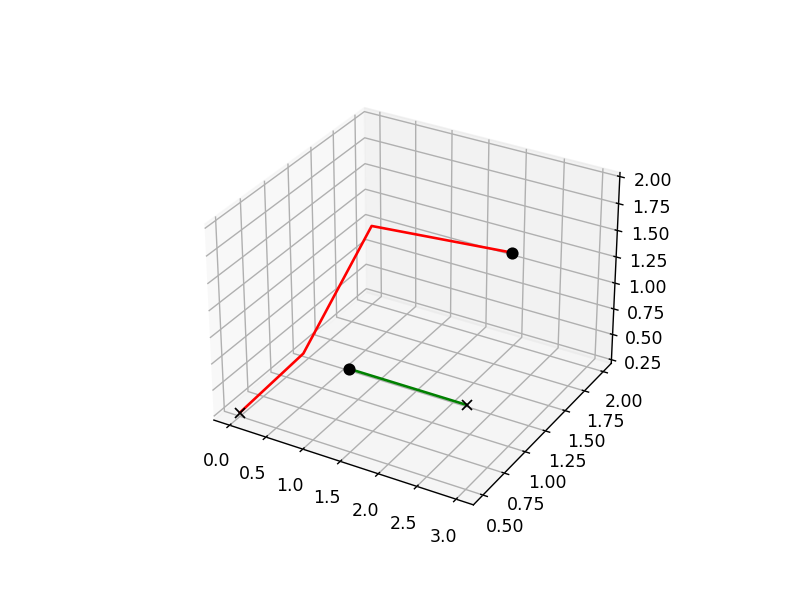

In [7]:
# def xyz_over_time_figure(xyz_list):
def xyz_over_time_figure(ax, xyz_list, target_xyz, color='gray', label=None):

    '''
    - write function to display x, y, z posns over time
        - inputs: xyz_list, a list of lists of xyz coords
        - take in the CSV file for this so we don't have to write 
            code for it that depends on prev. outputs in the Jupyter notebook
        - look up a python library that can do 3D plots you can rotate
        - find out how to do line plots
        - have target_posn be an input; calculate initial_posn from array
            indexing
        - outputs: a figure; display it when ready
    '''
    xdata = [posn[0] for posn in xyz_list]
    ydata = [posn[1] for posn in xyz_list]
    zdata = [posn[2] for posn in xyz_list]
    ax.plot(xdata, ydata, zdata, color=color, label=label)

    #Legend handling    
        
    if "Start" not in ax.get_legend_handles_labels()[1]:
        ax.plot(*xyz_list[0], color='black', marker='o', label="Start")
    else:
        ax.plot(*xyz_list[0], color='black', marker='o')
        
    if "End" not in ax.get_legend_handles_labels()[1]:
        ax.plot(*xyz_list[-1], color='black', marker='x', label="End")
    else:
        ax.plot(*xyz_list[-1], color='black', marker='x')

    return ax

####

#sample x, y, z
xyz_test = [
    [3, 1, 2],
    [0, 2, 1],
    [0.25, 1, 0.5],
    [0, 0.5, 0.25]
]

xyz_test2 = [
    [1.5, 0.5, 1],
    [3, 0.5, 1]
]

target_xyz = [0, 0, 0]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = xyz_over_time_figure(ax, xyz_test, target_xyz, 'red')
ax = xyz_over_time_figure(ax, xyz_test2, target_xyz, 'green')

plt.show()


In [8]:
def IKinBodyIterates(Blist, M, T, thetalist0, eomg, ev, max_iter):
    """Computes inverse kinematics in the body frame for an open chain robot

    :param Blist: The joint screw axes in the end-effector frame when the
                  manipulator is at the home position, in the format of a
                  matrix with axes as the columns
    :param M: The home configuration of the end-effector
    :param T: The desired end-effector configuration Tsd
    :param thetalist0: An initial guess of joint angles that are close to
                       satisfying Tsd
    :param eomg: A small positive tolerance on the end-effector orientation
                 error. The returned joint angles must give an end-effector
                 orientation error less than eomg
    :param ev: A small positive tolerance on the end-effector linear position
               error. The returned joint angles must give an end-effector
               position error less than ev
    :return thetalist: Joint angles that achieve T within the specified
                       tolerances,
    :return success: A logical value where TRUE means that the function found
                     a solution and FALSE means that it ran through the set
                     number of maximum iterations without finding a solution
                     within the tolerances eomg and ev.
    Uses an iterative Newton-Raphson root-finding method.
    The maximum number of iterations before the algorithm is terminated has
    been hardcoded in as a variable called maxiterations. It is set to 20 at
    the start of the function, but can be changed if needed.

    Example Input:
        Blist = np.array([[0, 0, -1, 2, 0,   0],
                          [0, 0,  0, 0, 1,   0],
                          [0, 0,  1, 0, 0, 0.1]]).T
        M = np.array([[-1, 0,  0, 0],
                      [ 0, 1,  0, 6],
                      [ 0, 0, -1, 2],
                      [ 0, 0,  0, 1]])
        T = np.array([[0, 1,  0,     -5],
                      [1, 0,  0,      4],
                      [0, 0, -1, 1.6858],
                      [0, 0,  0,      1]])
        thetalist0 = np.array([1.5, 2.5, 3])
        eomg = 0.01
        ev = 0.001
    Output:
        (np.array([1.57073819, 2.999667, 3.14153913]), True)
    """
    thetalist = np.array(thetalist0).copy()
    i = 0
    maxiterations = max_iter
    Vb = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                      thetalist)), T)))
    err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
          or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
    
    joint_vectors = []
    ang_error_array = []
    lin_error_array = []

    while i < maxiterations: #edited the loop condition so we could print one more time
        
        T_curr = mr.FKinBody(M, Blist, thetalist)
        [mag_w, mag_v] = calculate_V_error(Vb)
        
        print(f"\nIteration {i}:\n")
        print(f"Joint vector: \n{thetalist.round(3).tolist()}\n")    
        print(f"SE(3) end-effector config: \n{T_curr.round(3)}\n")        
        print(f"          error twist V_b: {Vb.round(3).tolist()}")
        print(f"angular error ||omega_b||: {round(mag_w, 4)}")
        print(f"     linear error ||v_b||: {round(mag_v, 4)}")
        
        joint_vectors.append(thetalist)
        ang_error_array.append(mag_w)
        lin_error_array.append(mag_v)
        
        #------------------#
        if not err: #if error is less than threshold, exit the loop
            break
        
        #-------------------#
        #set up next iteration of loop
        
        thetalist = thetalist \
                    + np.dot(np.linalg.pinv(mr.JacobianBody(Blist, \
                                                         thetalist)), Vb)
        i = i + 1
        Vb \
        = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                       thetalist)), T)))
        
        err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
              or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
        
        
    return joint_vectors, not err, ang_error_array, lin_error_array

#####

In [9]:
#try to find the joint vector that IKinBody returns to see if my function is working
theta_list_test = [
    1.646, -0.974, 1.175, 0, 0, 0
] #yields p = [-0.236, 0.588, 0.270]

theta_list_sol, success = mr.IKinBody(Blist, M, Tsd, theta_list_test, eomg, ev)
display(theta_list_sol.round(4).tolist())
display(success)

[1.7417, -1.1987, 1.3008, -0.102, 1.7417, 0.0]

True

# Problem 2

Below, this set of initial joint angles converges within 3 <= i <= 5 iterations.

In [10]:
short_iterates = 5
long_iterates = 20

joint_vectors_short, success_short, ang_error_short, lin_error_short = \
    IKinBodyIterates(Blist, M, Tsd, theta_list_test, eomg, ev, short_iterates)


Iteration 0:

Joint vector: 
[1.646, -0.974, 1.175, 0.0, 0.0, 0.0]

SE(3) end-effector config: 
[[ 0.074 -0.015 -0.997 -0.236]
 [-0.977  0.199 -0.075  0.588]
 [ 0.2    0.98   0.     0.269]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.165, -1.64, -0.153, -0.029, 0.084, -0.025]
angular error ||omega_b||: 1.6553
     linear error ||v_b||: 0.092

Iteration 1:

Joint vector: 
[1.527, -1.284, 1.413, 0.036, 1.523, -0.117]

SE(3) end-effector config: 
[[-0.994 -0.11  -0.004 -0.088]
 [-0.022  0.162  0.986  0.579]
 [-0.108  0.981 -0.164  0.339]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.164, -0.013, 0.109, 0.112, 0.019, 0.021]
angular error ||omega_b||: 0.1977
     linear error ||v_b||: 0.1151

Iteration 2:

Joint vector: 
[1.757, -1.226, 1.357, -0.133, 1.744, 0.038]

SE(3) end-effector config: 
[[-0.999  0.038 -0.013 -0.207]
 [-0.013 -0.001  1.     0.585]
 [ 0.038  0.999  0.002  0.343]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.002, -

Below, this set of initial joint angles converges in 10 < i < 20 iterations. I thought it wouldn't converge, but it found a solution with very high values of theta.

In [11]:
theta_list_test2 = [
    1.1, -2.0, 1.4, 0, 0, 0
] #achieves p = [-0.08, 0.265, 0.619]
#target p is [-0.2, 0.6, 0.35]

joint_vectors_long, success_long, ang_error_long, lin_error_long = \
    IKinBodyIterates(Blist, M, Tsd, theta_list_test2, eomg, ev, long_iterates)


Iteration 0:

Joint vector: 
[1.1, -2.0, 1.4, 0.0, 0.0, 0.0]

SE(3) end-effector config: 
[[-0.374 -0.256 -0.891 -0.079]
 [-0.736 -0.503  0.454  0.265]
 [-0.565  0.825  0.     0.618]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.33, -1.065, 0.538, 0.013, -0.302, 0.334]
angular error ||omega_b||: 1.238
     linear error ||v_b||: 0.4507

Iteration 1:

Joint vector: 
[0.768, -2.14, 2.246, 0.045, 0.791, -0.212]

SE(3) end-effector config: 
[[-0.994 -0.104  0.018  0.031]
 [ 0.006  0.107  0.994  0.262]
 [-0.106  0.989 -0.106  0.303]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.107, 0.012, 0.106, 0.23, 0.077, 0.334]
angular error ||omega_b||: 0.151
     linear error ||v_b||: 0.4128

Iteration 2:

Joint vector: 
[3.528, -1.183, 1.811, -1.029, 3.487, 0.574]

SE(3) end-effector config: 
[[-0.585  0.808 -0.067 -0.441]
 [ 0.068  0.131  0.989 -0.214]
 [ 0.808  0.574 -0.132  0.154]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.154, 0.001, -0.947

In [12]:
#save data to csv so we can access it later.
csv_long = "long_iterates.csv"
f = open(csv_long, 'w') #clear out prev. results
f.close()

for vec in joint_vectors_long:
    write_csv_line(csv_long, vec)

csv_short = "short_iterates.csv"
f = open(csv_short, 'w') #clear out prev. results
f.close()

for vec in joint_vectors_short:
    write_csv_line(csv_short, vec)

# Problem 3

Although it isn't part of the problem, I wanted to test the end-effector configuration in CoppeliaSim for not just short-iterates, but also long-iterates. Because CoppeliaSim UR5 scene 1 can only take in angles between (-2pi, 2pi), we can't put the angles from long_iterates.csv directly into the scene. I found equivalent angles by adding n*(2pi) to the angles in long_iterates[end].

In [17]:
#convert angles to be within [-2pi, 2pi]
final_angles_new = np.array([(i % (2*np.pi)) for i in joint_vectors_long[-1]])
print("\nLast joint vector in long_iterates, original:")
print(np.array(joint_vectors_long[-1]).round(3).tolist())
print("\nBounded by (-2pi, 2pi):")
print(final_angles_new.round(3).tolist())


Last joint vector in long_iterates, original:
[300.588, -46.069, 155.478, -370.161, 76.403, -398.982]

Bounded by (-2pi, 2pi):
[5.278, 4.197, 4.681, 0.547, 1.005, 3.142]


In [18]:
print(f"Last joint vector in short_iterates: \n{joint_vectors_short[-1].round(3).tolist()}")

Last joint vector in short_iterates: 
[1.742, -1.199, 1.301, -0.102, 1.742, 0.0]


### UR5 at final position generated by short_iterates:

In [19]:
display(HTML("<table><tr><td><img src='https://i.imgur.com/FQi7gf7.png' width=1000' height='700'></table>"))

# Problem 4

<IPython.core.display.Javascript object>


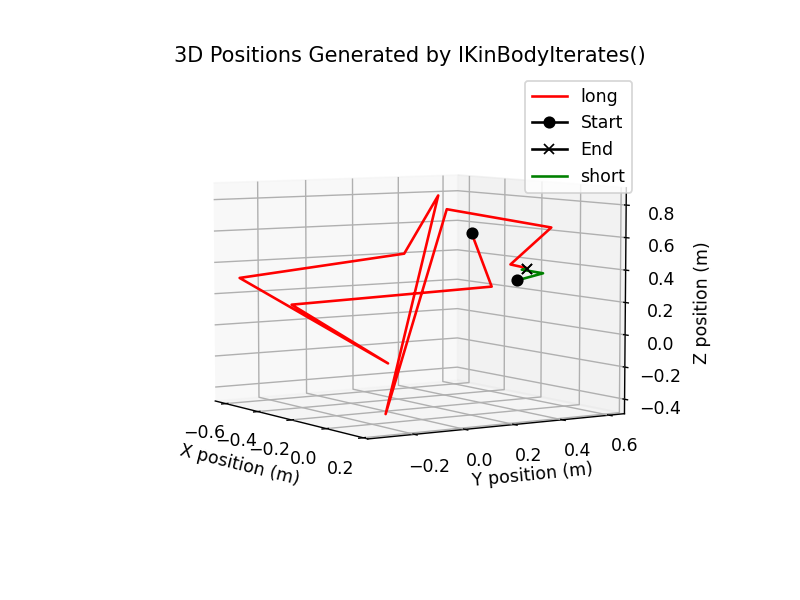

In [20]:
#plot our data
xyz_long = convert_theta_to_xyz(M, Blist,csv_long)
xyz_short = convert_theta_to_xyz(M, Blist,csv_short)
target_xyz = mr.TransToRp(Tsd)[1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = xyz_over_time_figure(ax, xyz_long, target_xyz, 'red', label='long')
ax = xyz_over_time_figure(ax, xyz_short, target_xyz, 'green', label='short')

ax.set_title("3D Positions Generated by IKinBodyIterates()")
ax.set_xlabel("X position (m)")
ax.set_ylabel("Y position (m)")
ax.set_zlabel("Z position (m)")
ax.legend()

plt.show()

# Problems 5+6

<IPython.core.display.Javascript object>


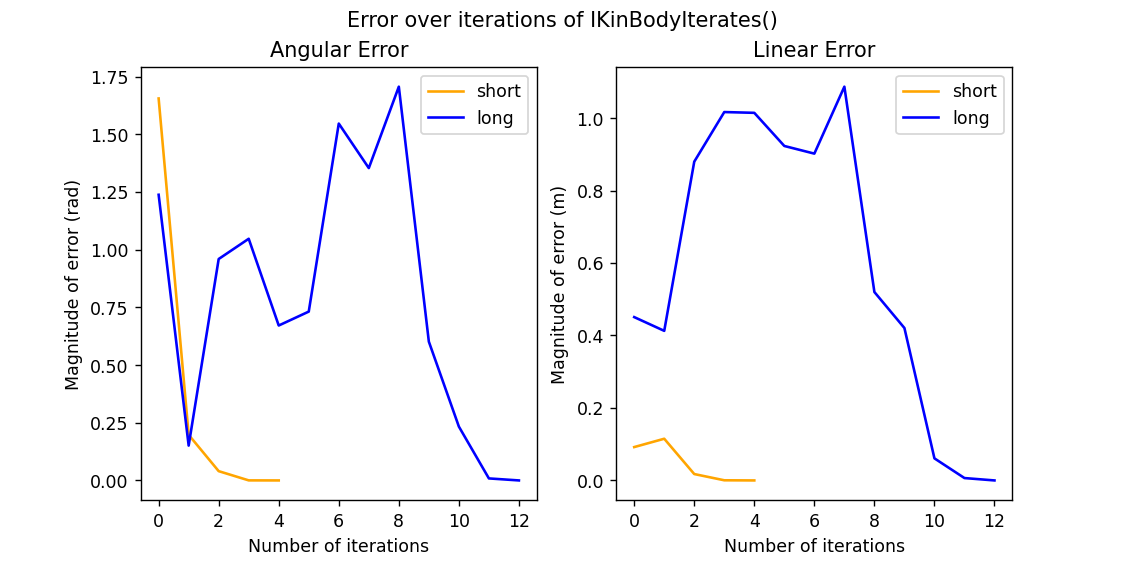

Text(0.5, 0.98, 'Error over iterations of IKinBodyIterates()')

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2)

#-------------------------------#

ax1.plot(ang_error_short, color='orange', label='short')
ax1.plot(ang_error_long, color='blue', label='long')
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("Magnitude of error (rad)")
ax1.set_title("Angular Error")
ax1.legend()

#-------------------------------#

ax2.plot(lin_error_short, color='orange', label='short')
ax2.plot(lin_error_long, color='blue', label='long')
ax2.set_xlabel("Number of iterations")
ax2.set_ylabel("Magnitude of error (m)")
ax2.set_title("Linear Error")
ax2.legend()

#-------------------------------#

fig.set_size_inches(9,4.5)
plt.suptitle("Error over iterations of IKinBodyIterates()")

# Problem 7

If an initial guess for $\theta_i$ is far away from the desired end effector joint angle $\theta_d$, the slope of the curve representing $x - f(\theta)$ - where $f(\theta)$ is the xyz position of the end effector at joint vector $\theta$ - may be of any magnitude. The calculated value of J pseudo-inverse may not yield a next guess $\theta_{i+1}$ that is close to the desired end effector configuration. If the "slope" $J(\theta)$ is close to 0 at a far-away value of $\theta$, then $J^+$ becomes large, and the value of $\Delta \theta = J^+(\theta)V_b$ for the next iteration of Newton-Raphson will be high. This causes the system to get farther away from converging on a solution.

In [22]:
print("\nJoint vectors from short-iterates:")
short_list = [i.round(3).tolist() for i in joint_vectors_short]
for ind, val in enumerate(short_list):
    print(f"{ind} {val}", end='\n')
    
print("\nJoint vectors from long-iterates:")
long_list = [i.round(3).tolist() for i in joint_vectors_long]
for ind, val in enumerate(long_list):
    print(f"{ind} {val}", end='\n')



Joint vectors from short-iterates:
0 [1.646, -0.974, 1.175, 0.0, 0.0, 0.0]
1 [1.527, -1.284, 1.413, 0.036, 1.523, -0.117]
2 [1.757, -1.226, 1.357, -0.133, 1.744, 0.038]
3 [1.741, -1.199, 1.302, -0.103, 1.741, 0.0]
4 [1.742, -1.199, 1.301, -0.102, 1.742, 0.0]

Joint vectors from long-iterates:
0 [1.1, -2.0, 1.4, 0.0, 0.0, 0.0]
1 [0.768, -2.14, 2.246, 0.045, 0.791, -0.212]
2 [3.528, -1.183, 1.811, -1.029, 3.487, 0.574]
3 [2.266, -2.711, 4.24, -2.917, 2.407, -1.47]
4 [3.576, -1.008, 1.386, -2.01, 3.208, -2.126]
5 [2.382, -1.475, 4.869, -16.943, 3.084, -13.596]
6 [4.747, -1.084, -0.77, -34.538, 4.045, -36.452]
7 [297.857, -42.965, 151.999, -370.317, 80.221, -398.524]
8 [301.047, -45.926, 156.188, -370.616, 76.536, -400.868]
9 [300.171, -45.723, 155.739, -370.166, 76.692, -399.102]
10 [300.678, -45.988, 155.414, -370.113, 76.363, -399.243]
11 [300.58, -46.063, 155.477, -370.162, 76.404, -398.981]
12 [300.588, -46.069, 155.478, -370.161, 76.403, -398.982]


What seems strange to me about the joint vectors is the disparity in the scale of how much theta can change from one iteration of Newton-Raphson to the next. In long-iterates, changes in each joint angle are relatively small (<2pi radians) between iterations 0-6 and 7-12 (except for joints 4 and 6 in iterations 5-6). There's a massive leap in joint angles calculated between iterations 7-8, but after that there are no more large changes in theta. This tells me that Newton-Raphson root finding is volatile, and that initial joint angle guesses have to be close to the desired configuration in order for numerical IK to work.